In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
import scipy.constants as const
from beam.beams import electronbeam
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.style.use('notes')
from beam import interactions
from lens import profile
from scipy.interpolate import interp1d

path = '/media/robert/Data_Storage/Data/Super-Adiabatic_Ramp_Propagation/Assumed_Beta_Fixed_Waist/'

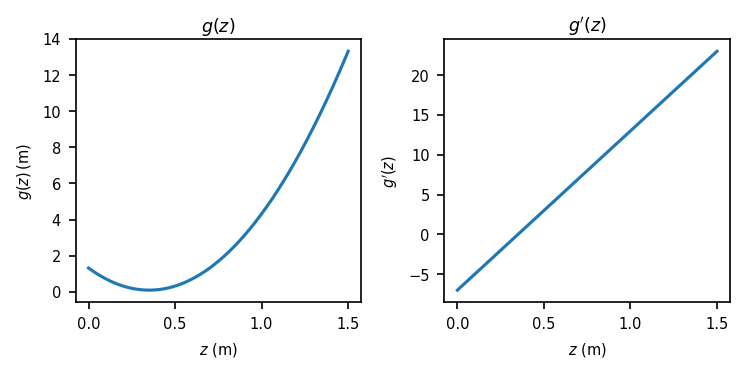

In [2]:
# Lets fix the waist location and waist beta function and look at g(z)
g = lambda z: (z-z0)**2/bs + bs - 1/kb
gp = lambda z: 2*(z-z0)/bs
gpp = lambda z: 2/bs

kb = 210.37
bs = 0.1
z0 = 0.35

Nz = 10000
z1 = 0.5
Z = 1.5
z = np.linspace(0, Z, Nz)
plt.figure(figsize=(5, 2.5), dpi=150)
gs = gridspec.GridSpec(1, 2)
plt.subplot(gs[0, 0])
plt.plot(z, g(z))
plt.title(r"$g(z)$")
plt.xlabel(r'$z$ (m)')
plt.ylabel(r"$g(z)\,\mathrm{(m)}$")

plt.subplot(gs[0, 1])
plt.plot(z, gp(z))
plt.title(r"$g'(z)$")
plt.xlabel(r'$z$ (m)')
plt.ylabel(r"$g'(z)$")

plt.tight_layout()
plt.show()

0.375 Negative plasma density: False
0.49 Negative plasma density: False
0.605 Negative plasma density: False
0.72 Negative plasma density: False
0.835 Negative plasma density: False
0.95 Negative plasma density: False


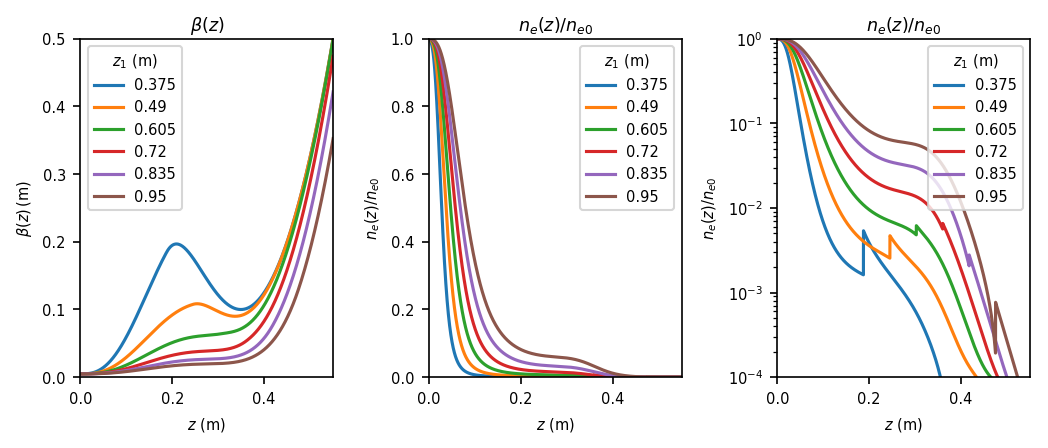

In [3]:
# Let's start with the simple cubic and look at how the ramp varies
f = lambda z: np.piecewise(z, [np.logical_and(0<=z, z<(z1/2)), np.logical_and((z1/2)<=z, z<z1), z1<=z],
                            [lambda z: 4*(z/z1)**3, lambda z: 4*((z-z1)/z1)**3+1, 1])
fp = lambda z: np.piecewise(z, [np.logical_and(0<=z, z<(z1/2)), np.logical_and((z1/2)<=z, z<z1), z1<=z],
                            [lambda z: 12*z**2/z1**3, lambda z: 12*(z-z1)**2/z1**3, 0])
fpp = lambda z: np.piecewise(z, [np.logical_and(0<=z, z<(z1/2)), np.logical_and((z1/2)<=z, z<z1), z1<=z],
                            [lambda z: 24*z/z1**3, lambda z: 24*(z-z1)/z1**3, 0])

b = lambda z: 1/kb + g(z)*f(z)
bp = lambda z: g(z)*fp(z) + gp(z)*f(z)
bpp = lambda z: g(z)*fpp(z)+2*gp(z)*fp(z)+gpp(z)*f(z)

ne = lambda z: 1/(kb**2*b(z)**2)*(1+bp(z)**2/4)-bpp(z)/(2*kb**2*b(z))

z1Arr = [0.375, 0.45, 0.525, 0.6, 0.675, 0.75, 0.825, 0.95]
z1Arr = np.linspace(0.375, 0.95, 6)
plt.figure(figsize=(7, 3), dpi=150)
gs = gridspec.GridSpec(1, 3)
plt.subplot(gs[0, 0])
for i in z1Arr:
    z1 = i
    plt.plot(z, b(z))
plt.title(r"$\beta(z)$")
plt.xlabel(r'$z$ (m)')
plt.ylabel(r"$\beta(z)\,\mathrm{(m)}$")
plt.legend(z1Arr, title=r'$z_1$ (m)')
plt.xlim(0, 0.55)
plt.ylim(0, 0.5)

plt.subplot(gs[0, 1])
for i in z1Arr:
    z1 = i
    plt.plot(z, ne(z))
    print(z1, 'Negative plasma density:', any(ne(z)<-1e-18))
plt.title(r"$n_e(z)/n_{e0}$")
plt.xlabel(r'$z$ (m)')
plt.ylabel(r"$n_e(z)/n_{e0}$")
plt.legend(z1Arr, title=r'$z_1$ (m)')
plt.xlim(0.0, 0.55)
plt.ylim(0.0, 1)

plt.subplot(gs[0, 2])
for i in z1Arr:
    z1 = i
    plt.plot(z, ne(z))
plt.title(r"$n_e(z)/n_{e0}$")
plt.xlabel(r'$z$ (m)')
plt.ylabel(r"$n_e(z)/n_{e0}$")
plt.legend(z1Arr, title=r'$z_1$ (m)')
plt.yscale('log')
plt.xlim(0.0, 0.55)
plt.ylim(1e-4, 1)

plt.tight_layout()
plt.show()

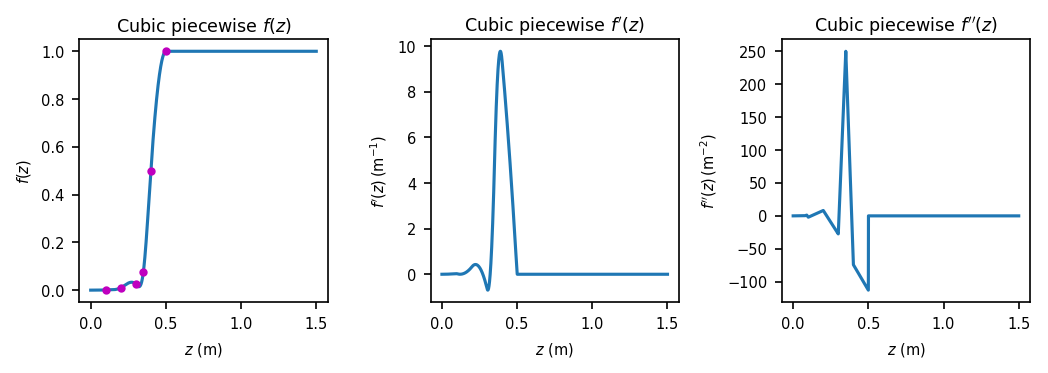

Negative plasma density: False


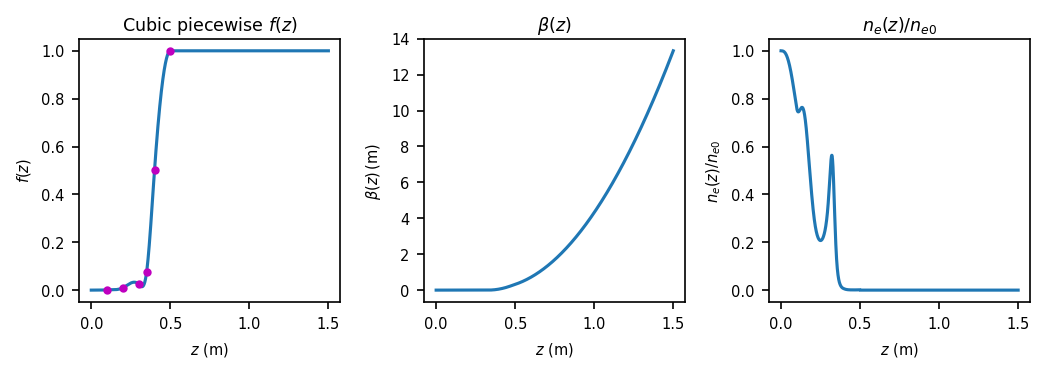

In [4]:
# The best option is probably still a cubic spline
from scipy.interpolate import CubicSpline
def spline(z, fz):
    z_cub = np.linspace(0, z[0], 10, endpoint=False)
    a = fz[0]/z[0]**3
    fz_cub = a*z_cub**3
    z_tot = np.concatenate([z_cub, z])
    fz_tot = np.concatenate([fz_cub, fz])
    return CubicSpline(z_tot, fz_tot, bc_type='clamped', extrapolate=False)
def spline_f(z, fz_spline):
    fz = fz_spline(z)
    fz[np.isnan(fz)] = 1.0
    return fz
def spline_fp(z, fz_spline):
    fz = fz_spline(z, 1)
    fz[np.isnan(fz)] = 0.0
    return fz
def spline_fpp(z, fz_spline):
    fz = fz_spline(z, 2)
    fz[np.isnan(fz)] = 0.0
    return fz
zKnot = np.array([0.1, 0.2, 0.3, 0.35, 0.4, 0.5])
fzKnot = np.array([0.001, 0.01, 0.025, 0.075, 0.5, 1.0])
splineF = spline(zKnot, fzKnot)

f = lambda z: spline_f(z, splineF)
fp = lambda z: spline_fp(z, splineF)
fpp = lambda z: spline_fpp(z, splineF)

plt.figure(figsize=(7, 2.5), dpi=150)
gs = gridspec.GridSpec(1, 3)
plt.subplot(gs[0, 0])
plt.plot(z, f(z))
plt.plot(zKnot, fzKnot, 'm.', linestyle='none')
plt.title(r"Cubic piecewise $f(z)$")
plt.xlabel(r'$z$ (m)')
plt.ylabel(r"$f(z)$")

plt.subplot(gs[0, 1])
plt.plot(z, fp(z))
plt.title(r"Cubic piecewise $f'(z)$")
plt.xlabel(r'$z$ (m)')
plt.ylabel(r"$f'(z)\,\mathrm{(m^{-1})}$")

plt.subplot(gs[0, 2])
plt.plot(z, fpp(z))
plt.title(r"Cubic piecewise $f''(z)$")
plt.xlabel(r'$z$ (m)')
plt.ylabel(r"$f''(z)\,\mathrm{(m^{-2})}$")

plt.tight_layout()
plt.show()

# Plasma density and beta function
plt.figure(figsize=(7, 2.5), dpi=150)
gs = gridspec.GridSpec(1, 3)
plt.subplot(gs[0, 0])
plt.plot(z, f(z))
plt.plot(zKnot, fzKnot, 'm.', linestyle='none')
plt.title(r"Cubic piecewise $f(z)$")
plt.xlabel(r'$z$ (m)')
plt.ylabel(r"$f(z)$")

plt.subplot(gs[0, 1])
plt.plot(z, b(z))
plt.title(r"$\beta(z)$")
plt.xlabel(r'$z$ (m)')
plt.ylabel(r"$\beta(z)\,\mathrm{(m)}$")

plt.subplot(gs[0, 2])
plt.plot(z, ne(z))
plt.title(r"$n_e(z)/n_{e0}$")
plt.xlabel(r'$z$ (m)')
plt.ylabel(r"$n_e(z)/n_{e0}$")
print('Negative plasma density:', any(ne(z)<-1e-18))

plt.tight_layout()
plt.show()

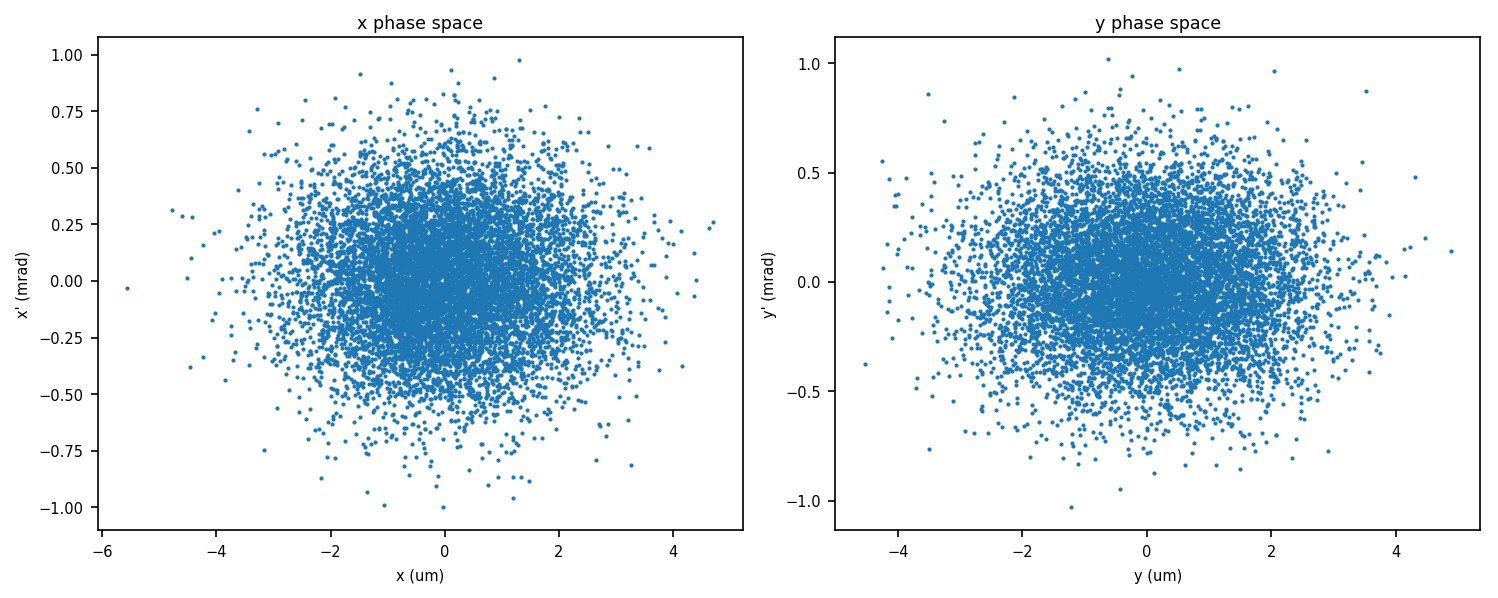

In [5]:
# Lets test this using the macro particle propagation
# Create the plasma desnity
Nz = 2000
zsim = np.linspace(0, Z, Nz)
zsim *= 1e6
#ne = fne(zsim)
class plasmaCls():
    def __init__(self):
        """ Empy init function """
    def get_ne(self, z):
        return 0.5*ne(z*1e-6)
    def dgammadz(self, ne):
        return 0.0
plasmaDen = plasmaCls()
# Create the electron beam
beta = 0.10   # Waist beta function in (m)
waist = -0.361897 # Vacuum waist position (m)
gamma = 20000 # Beam relativistic Lorentz factor
#betaBeam = beta+(-ramp_zl-waist)**2/beta
#alphaBeam = (ramp_zl+waist)/beta
betaBeam = 1/kb
alphaBeam = 0.0
electronParams = {
    'name' : 'TestBeam',
    'path' : path,
    'load' : False,
    'N' : 10000,
    'gamma' : gamma,
    'emittance' : 7e-6,
    'betax' : betaBeam,
    'betay' : betaBeam,
    'alphax' : alphaBeam,
    'alphay' : alphaBeam,
    'sigmaz' : 5e-6,
    'dE' : 0.01
}

beam = electronbeam.GaussianElectronBeam(electronParams)
beam.plot_current_phase()

In [6]:
dumpPer = 1
interactions.electron_plasma(beam, plasmaDen, zsim, dumpPer, 4)
m = int(Nz/dumpPer)
beam_z = np.linspace(0.0, Z, m)
dz = Z/(m-1)
beam_ne = 0.5*ne(beam_z)

Initial emittance: 6.8827 um rad
Final emittance:   6.8831 um rad


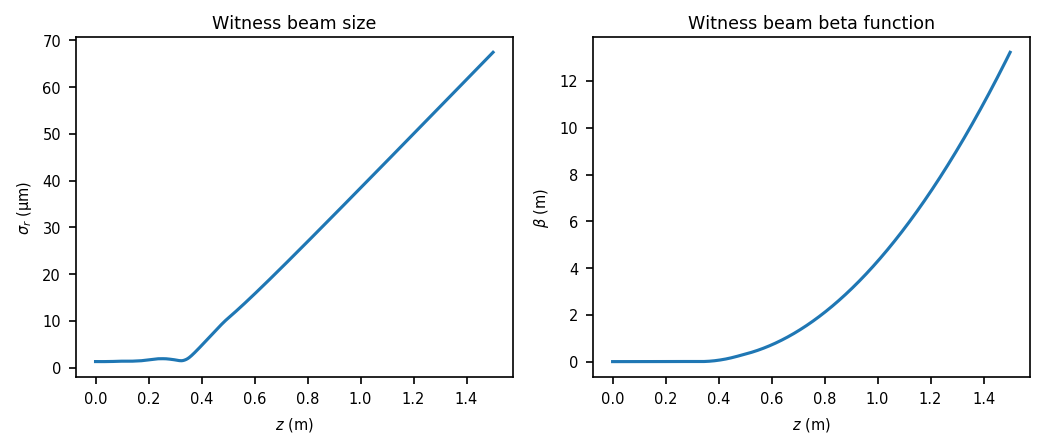

In [7]:
# Check to make sure everything seems correct
beam_sigmar = np.zeros(m, dtype='double')
beam_eps = np.zeros(m, dtype='double')
for i in range(m):
    beam_sigmar[i] = np.average(beam.get_sigmar(i))
    beam_eps[i] = np.average(beam.get_emittance_n(i))
beam_beta = (beam_sigmar)**2 / beam_eps * gamma
print('Initial emittance: %0.4f um rad' % (beam_eps[0]*1e6))
print('Final emittance:   %0.4f um rad' % (beam_eps[m-1]*1e6))

plt.figure(figsize=(7, 3), dpi=150)
gs = gridspec.GridSpec(1, 2)
plt.subplot(gs[0,0])
plt.plot(beam_z, beam_sigmar*1e6)
plt.title('Witness beam size')
plt.xlabel(r'$z$ (m)')
plt.ylabel(r'$\sigma_r$ ($\mathrm{\mu m}$)')

plt.subplot(gs[0,1])
plt.plot(beam_z, beam_beta)
plt.title('Witness beam beta function')
plt.xlabel(r'$z$ (m)')
plt.ylabel(r'$\beta$ (m)')

plt.tight_layout()
plt.show()